# Cross-Asset Volatility Information Flow: EUR/USD vs EUR/GBP

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:

df = pd.read_csv(
    "/Users/nathr/Downloads/HISTDATA_COM_ASCII_EURUSD_M1202511/eurusdnov.csv",
    sep=";",
    header=None,
    names=["datetime", "open", "high", "low", "close", "volume"]
)

# Split datetime
df["datetime"] = pd.to_datetime(
    df["datetime"],
    format="%Y%m%d %H%M%S"
)

df = df.set_index("datetime")

print(df.head())


                        open     high      low    close  volume
datetime                                                       
2025-11-02 17:00:00  1.15294  1.15324  1.15294  1.15324       0
2025-11-02 17:01:00  1.15324  1.15329  1.15289  1.15328       0
2025-11-02 17:02:00  1.15328  1.15328  1.15328  1.15328       0
2025-11-02 17:03:00  1.15295  1.15328  1.15295  1.15328       0
2025-11-02 17:04:00  1.15295  1.15295  1.15295  1.15295       0


In [5]:
df2 = pd.read_csv(
    "/Users/nathr/Downloads/HISTDATA_COM_ASCII_EURGBP_M1202511/eurgbpnov.csv",
    sep=";",
    header=None,
    names=["datetime", "open", "high", "low", "close", "volume"]
)

# Split datetime
df2["datetime"] = pd.to_datetime(
    df2["datetime"],
    format="%Y%m%d %H%M%S"
)

df2 = df2.set_index("datetime")

print(df2.head())


                        open     high      low    close  volume
datetime                                                       
2025-11-02 17:04:00  0.87737  0.87737  0.87737  0.87737       0
2025-11-02 17:05:00  0.87738  0.87772  0.87711  0.87772       0
2025-11-02 17:06:00  0.87773  0.87773  0.87740  0.87773       0
2025-11-02 17:07:00  0.87772  0.87773  0.87741  0.87741       0
2025-11-02 17:08:00  0.87740  0.87771  0.87740  0.87771       0


In [9]:
combined = df.merge(df2, how='inner', left_index=True, right_index=True, suffixes=('_eurusd','_eurgbp'))
combined.head()

,open_eurusd,high_eurusd,low_eurusd,close_eurusd,volume_eurusd,open_eurgbp,high_eurgbp,low_eurgbp,close_eurgbp,volume_eurgbp
datetime,,,,,,,,,,
2025-11-02 17:04:00,1.15295,1.15295,1.15295,1.15295,0,0.87737,0.87737,0.87737,0.87737,0
2025-11-02 17:05:00,1.15306,1.15329,1.15295,1.15319,0,0.87738,0.87772,0.87711,0.87772,0
2025-11-02 17:06:00,1.15300,1.15331,1.15300,1.15302,0,0.87773,0.87773,0.87740,0.87773,0
2025-11-02 17:07:00,1.15303,1.15309,1.15303,1.15305,0,0.87772,0.87773,0.87741,0.87741,0
2025-11-02 17:08:00,1.15307,1.15309,1.15306,1.15309,0,0.87740,0.87771,0.87740,0.87771,0


## Assumptions & Parameters
- Volatility window: 30 minutes
- Max lag for correlation: 60 minutes


In [140]:
VOL_WINDOW = 10     # minutes
MAX_LAG = 60         # minutes


In [142]:
def compute_log_returns(df, price_col):
    return np.log(df[price_col]).diff()

def rolling_vol(r, vol_window):
    return r.rolling(vol_window).std()


In [144]:
r1 = compute_log_returns(combined, "close_eurusd")
r2 = compute_log_returns(combined, "close_eurgbp")

vol1 = rolling_vol(r1, VOL_WINDOW)
vol2 = rolling_vol(r2, VOL_WINDOW)


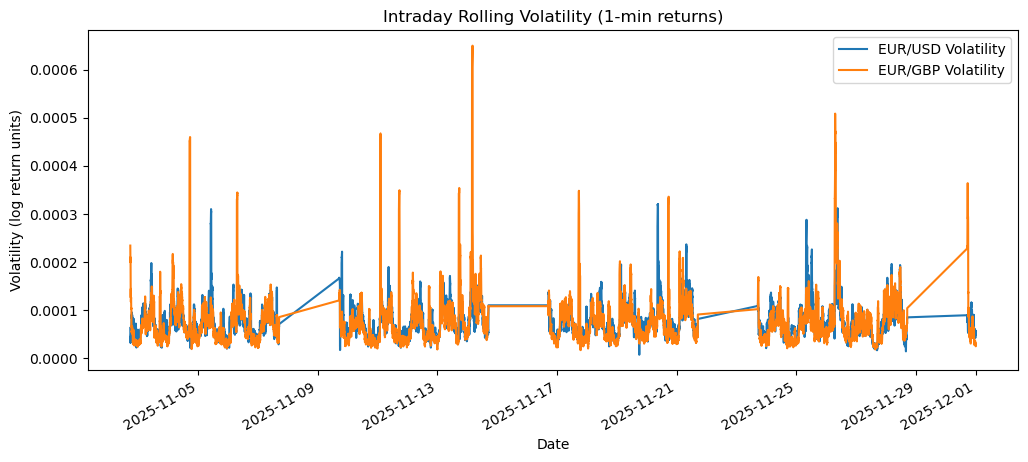

In [146]:
plt.figure(figsize=(12,5))
vol_eurusd.plot(label="EUR/USD Volatility")
vol_eurgbp.plot(label="EUR/GBP Volatility")
plt.title("Intraday Rolling Volatility (1-min returns)")
plt.xlabel("Date")
plt.ylabel("Volatility (log return units)")
plt.legend()
plt.show()


### Intraday Rolling Volatility

We compute rolling volatility from 1-minute log returns to measure
short-horizon market activity and stress.

Rolling volatility is preferred over raw returns because:
- It captures *intensity* rather than direction
- It is more stable across assets
- It is commonly used in cross-asset spillover analysis

A rolling window is used to:
- Reduce microstructure noise
- Approximate short-term realized volatility

The resulting series reflects how rapidly prices move over time.


In [124]:
def lagged_corr(x, y, MAX_LAG):
    lags = range(-MAX_LAG, MAX_LAG+1)
    return pd.Series(
        [x.corr(y.shift(l)) for l in lags],
        index=lags
    )


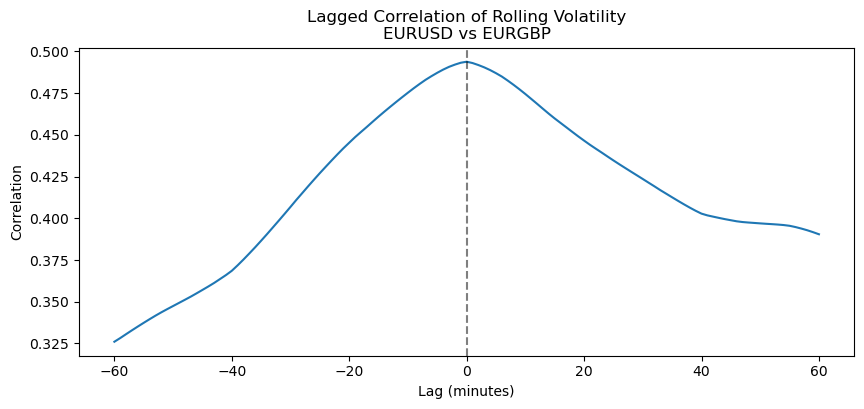

In [126]:
corrs = lagged_corr(vol1, vol2, MAX_LAG)

plt.figure(figsize=(10, 4))
corrs.plot()
plt.axvline(0, color="black", linestyle="--", alpha=0.5)

plt.title("Lagged Correlation of Rolling Volatility\nEURUSD vs EURGBP")
plt.xlabel("Lag (minutes)")
plt.ylabel("Correlation")

plt.show()


### Cross-Asset Volatility Correlation (Lagged)

To study volatility spillovers between EURUSD and EURGBP,
we compute the correlation between their rolling volatility series
across a range of time lags.

Interpretation:
- Lag < 0: EURUSD volatility leads EURGBP
- Lag = 0: Simultaneous co-movement
- Lag > 0: EURGBP volatility leads EURUSD

A strong peak away from zero would suggest a lead-lag relationship.
A peak at zero suggests shared contemporaneous shocks.
